<a href="https://colab.research.google.com/github/fabiobento/dnn-course-2024-1/blob/main/00_course_folder/cert_prof_time_series/class_03/TS%20-%20W3%20-%2011%20-%20LSTM%20(Laborat%C3%B3rio%202).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

adaptado de [Certificado Profissional Desenvolvedor do TensorFlow](https://www.coursera.org/professional-certificates/tensorflow-in-practice) de [Laurence Moroney](https://laurencemoroney.com/)

# Uso de um LSTM de várias camadas para previsão

Neste laboratório, você usará a mesma arquitetura RNN do primeiro laboratório, mas empilhará camadas [LSTM](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM) em vez de `SimpleRNN`.

## Importações

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

2024-04-13 12:55:52.938788: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-13 12:55:52.960762: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-13 12:55:52.960789: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-13 12:55:52.960803: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-13 12:55:52.965052: I tensorflow/core/platform/cpu_feature_g

## Utilitários

In [2]:
def plot_series(time, series, format="-", start=0, end=None):
    """
    Visualiza dados de séries temporais

    Args:
      time (array of int) - contém as etapas de tempo
      series (array of int) - contém as medidas para cada etapa de tempo
      format - estilo de linha ao plotar o gráfico
      start - primeiro passo de tempo a ser plotado
      end - última etapa de tempo a ser plotada
    """

    # Configuração das dimensões da figura do gráfico
    plt.figure(figsize=(10, 6))
    
    if type(series) is tuple:

      for series_num in series:
        # Plotar os dados da série temporal
        plt.plot(time[start:end], series_num[start:end], format)

    else:
      # Plotar os dados da série temporal
      plt.plot(time[start:end], series[start:end], format)

    # Rotular o eixo x
    plt.xlabel("Time")

    # Rotular o eixo y
    plt.ylabel("Value")

    # Sobrepor uma grade no gráfico
    plt.grid(True)

    # Desenhe o gráfico na tela
    plt.show()

def trend(time, slope=0):
    """
    Gera dados sintéticos que seguem uma linha reta com um valor de inclinação.

    Args:
      time (vetor de int) - contém as etapas de tempo
      slope (float) - determina a direção e a inclinação da linha

    Retorna:
      series (vetor de float) - medições que seguem uma linha reta
    """

    # Calcula a série linear dada a inclinação
    series = slope * time

    return series

def seasonal_pattern(season_time):
    """
    Apenas um padrão arbitrário, você pode alterá-lo se desejar
    
    Args:
      season_time (vetor de float) - contém as medições por etapa de tempo

    Retorna:
      data_pattern (vetor de float) - contém os valores de medição revisados de acordo com o padrão definido. 
                                  de acordo com o padrão definido
    """

    # Gerar os valores usando um padrão arbitrário
    data_pattern = np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))
    
    return data_pattern

def seasonality(time, period, amplitude=1, phase=0):
    """
    Repete o mesmo padrão em cada período

    Args:
      time (vetor de int) - contém as etapas de tempo
      period (int) - número de etapas de tempo antes da repetição do padrão
      amplitude (int) - valor de pico medido em um período
      phase (int) - número de etapas de tempo para deslocar os valores medidos

    Retorna:
      data_pattern (vetor de float) - dados sazonais dimensionados pela amplitude definida
    """
    
    # Definir os valores medidos por período
    season_time = ((time + phase) % period) / period

    # Gera os dados sazonais dimensionados pela amplitude definida
    data_pattern = amplitude * seasonal_pattern(season_time)

    return data_pattern

def noise(time, noise_level=1, seed=None):
    """Gera um sinal ruidoso normalmente distribuído

    Args:
      time (array of int) - contém as etapas de tempo
      noise_level (float) - fator de escala para o sinal gerado
      seed (int) - semente do gerador de números para repetibilidade

    Retorna:
      noise (matriz de float) - o sinal ruidoso
    """

    # Inicializar o gerador de números aleatórios
    rnd = np.random.RandomState(seed)

    # Gerar um número aleatório para cada etapa de tempo e dimensionar pelo nível de ruído
    noise = rnd.randn(len(time)) * noise_level
    
    return noise

## Gerar os dados sintéticos

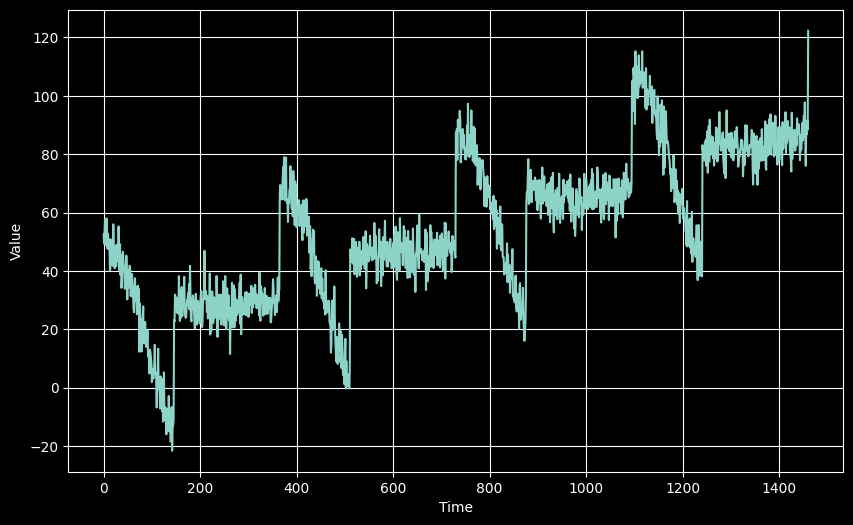

In [3]:
# Hiperparâmetros
time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Criar a série
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

# Atualizar com ruído
series += noise(time, noise_level, seed=42)

# Plotar os resultados
plot_series(time, series)

## Dividir o conjunto de dados

In [4]:
# Definir o tempo de divisão
split_time = 1000

# Obter o conjunto de treino
time_train = time[:split_time]
x_train = series[:split_time]

# Obter o conjunto de validação
time_valid = time[split_time:]
x_valid = series[split_time:]

## Prepare Features and Labels

In [5]:
# Hiperoparâmetros
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [6]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    """Gera janelas de conjunto de dados

    Args:
      series (vetor de float) - contém os valores da série temporal
      window_size (int) - o número de etapas de tempo a serem incluídas no recurso
      batch_size (int) - o tamanho do lote
      shuffle_buffer(int) - tamanho do buffer a ser usado para o método shuffle

    Retorna:
      dataset (TF Dataset) - Conjunto de dados TF contendo janelas de tempo
    """
  
    # Gerar um conjunto de dados TF a partir dos valores da série
    dataset = tf.data.Dataset.from_tensor_slices(series)
    
    # Janela de dados, mas só pega aqueles com o tamanho especificado
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    
    # Achatar as janelas, colocando seus elementos em um único lote
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Criar tuplas com recursos e rótulos 
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # Embaralhar as janelas
    dataset = dataset.shuffle(shuffle_buffer)
    
    # Criar lotes de janelas
    dataset = dataset.batch(batch_size).prefetch(1)
    
    return dataset

In [7]:
# Gerar as janelas do conjunto de dados
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

2024-04-13 12:55:54.195317: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-13 12:55:54.198984: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-13 12:55:54.199128: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

## Criar o modelo

Conforme mencionado, você trocará o `SimpleRNN` pelo `LSTM` neste laboratório. Ele também está definido como bidirecional abaixo, mas fique à vontade para revisá-lo mais tarde e ver os resultados obtidos. Os LSTMs são muito mais complexos em sua arquitetura interna do que os simpleRNNs. Ele implementa um estado de célula que lhe permite lembrar sequências melhor do que as implementações simples. Essa complexidade adicional resulta em um conjunto maior de parâmetros a serem treinados e você verá isso ao imprimir o resumo do modelo abaixo.

In [8]:
# Criar o modelo
model_tune = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[window_size]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

# Imprimir o resumo do modelo
model_tune.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 20, 1)             0         
                                                                 
 bidirectional (Bidirection  (None, 20, 64)            8704      
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 64)                24832     
 onal)                                                           
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
 lambda_1 (Lambda)           (None, 1)                 0         
                                                                 
Total params: 33601 (131.25 KB)
Trainable params: 33601 

## Ajuste a taxa de aprendizado

Como de costume, você escolherá uma taxa de aprendizagem executando o código de ajuste abaixo.

In [9]:
# Definir o agendador de taxa de aprendizado
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

# Inicializar o otimizador
optimizer = tf.keras.optimizers.SGD(momentum=0.9)

# Definir os parâmetros de treinamento
model_tune.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer)

# Treinar o modelo
history = model_tune.fit(dataset, epochs=100, callbacks=[lr_schedule])

Epoch 1/100


2024-04-13 12:55:57.399092: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8600


      1/Unknown - 3s 3s/step - loss: 7.9289

2024-04-13 12:55:57.873227: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x716df407a790 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-13 12:55:57.873245: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 2080 SUPER, Compute Capability 7.5
2024-04-13 12:55:57.910496: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


31/31 [==============================] - 3s 5ms/step - loss: 9.0220 - lr: 1.0000e-08
Epoch 2/100
31/31 [==============================] - 0s 6ms/step - loss: 9.0048 - lr: 1.1220e-08
Epoch 3/100
31/31 [==============================] - 0s 5ms/step - loss: 8.9867 - lr: 1.2589e-08
Epoch 4/100
31/31 [==============================] - 0s 5ms/step - loss: 8.9687 - lr: 1.4125e-08
Epoch 5/100
31/31 [==============================] - 0s 6ms/step - loss: 8.9511 - lr: 1.5849e-08
Epoch 6/100
31/31 [==============================] - 0s 3ms/step - loss: 8.9304 - lr: 1.7783e-08
Epoch 7/100
31/31 [==============================] - 0s 4ms/step - loss: 8.9100 - lr: 1.9953e-08
Epoch 8/100
31/31 [==============================] - 0s 5ms/step - loss: 8.8895 - lr: 2.2387e-08
Epoch 9/100
31/31 [==============================] - 0s 5ms/step - loss: 8.8688 - lr: 2.5119e-08
Epoch 10/100
31/31 [==============================] - 0s 4ms/step - loss: 8.8435 - lr: 2.8184e-08
Epoch 11/100
31/31 [=====================

(1e-08, 0.001, 0.0, 30.0)

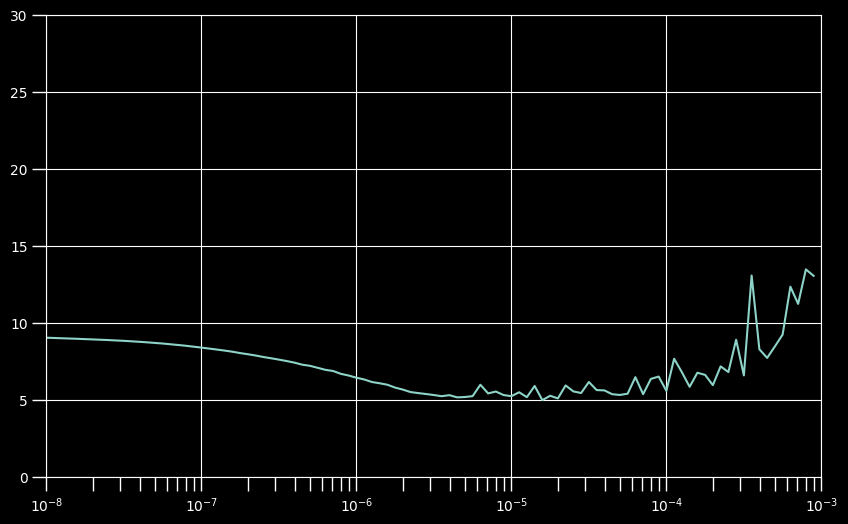

In [10]:
# Definir a matriz de taxa de aprendizado
lrs = 1e-8 * (10 ** (np.arange(100) / 20))

# Definir o tamanho da figura
plt.figure(figsize=(10, 6))

# Definir a grade
plt.grid(True)

# Plotar a perda em escala logarítmica
plt.semilogx(lrs, history.history["loss"])

# Aumentar o tamanho dos tickmarks
plt.tick_params('both', length=10, width=1, which='both')
# Definir os limites do gráfico
plt.axis([1e-8, 1e-3, 0, 30])

## Treinar o modelo

Em seguida, você pode continuar a treinar o modelo com a taxa de aprendizado escolhida. 

*Dica: ao fazer experimentos e executar diferentes iterações de um modelo, talvez você queira usar o método [`clear_session()`](https://www.tensorflow.org/api_docs/python/tf/keras/backend/clear_session) para organizar a memória usada pelo Keras. Isso é adicionado na primeira linha abaixo.*


In [11]:
# Redefinir estados gerados pelo Keras
tf.keras.backend.clear_session()

# Construir o modelo
model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
   tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

# Definir a taxa de aprendizado
learning_rate = 2e-6

# Definir o otimizador 
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

# Definir os parâmetros de treinamento
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# Treinar o modelo
history = model.fit(dataset,epochs=100)

Epoch 1/100
31/31 [==============================] - 3s 4ms/step - loss: 15.0525 - mae: 15.5457
Epoch 2/100
31/31 [==============================] - 0s 4ms/step - loss: 9.0837 - mae: 9.5666
Epoch 3/100


2024-04-13 12:56:21.203119: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4692949217869808434


31/31 [==============================] - 0s 5ms/step - loss: 7.4429 - mae: 7.9228
Epoch 4/100
31/31 [==============================] - 0s 5ms/step - loss: 6.8442 - mae: 7.3278
Epoch 5/100
31/31 [==============================] - 0s 10ms/step - loss: 6.4883 - mae: 6.9685
Epoch 6/100
31/31 [==============================] - 0s 6ms/step - loss: 6.3028 - mae: 6.7846
Epoch 7/100
31/31 [==============================] - 0s 4ms/step - loss: 6.1694 - mae: 6.6507
Epoch 8/100
31/31 [==============================] - 0s 4ms/step - loss: 6.0305 - mae: 6.5091
Epoch 9/100
31/31 [==============================] - 0s 6ms/step - loss: 5.9457 - mae: 6.4244
Epoch 10/100
31/31 [==============================] - 0s 4ms/step - loss: 5.9127 - mae: 6.3926
Epoch 11/100
31/31 [==============================] - 0s 3ms/step - loss: 5.8468 - mae: 6.3278
Epoch 12/100
31/31 [==============================] - 0s 4ms/step - loss: 5.7612 - mae: 6.2400
Epoch 13/100
31/31 [==============================] - 0s 3ms/step - 

## Previsão do modelo

Em seguida, você gerará lotes de janelas para gerar previsões que se alinham com o conjunto de validação.

In [12]:
def model_forecast(model, series, window_size, batch_size):
    """Usa um modelo de entrada para gerar previsões em janelas de dados

    Args:
      model (TF Keras Model) - modelo que aceita janelas de dados
      series (array of float) - contém os valores da série temporal
      window_size (int) - o número de etapas de tempo a serem incluídas na janela
      batch_size (int) - o tamanho do lote

    Retorna:
      forecast (matriz numpy) - matriz que contém as previsões
    """

    # Gerar um conjunto de dados TF a partir dos valores da série
    dataset = tf.data.Dataset.from_tensor_slices(series)
    
    # Janela de dados, mas só pega aqueles com o tamanho especificado
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)

    # Achatar as janelas, colocando seus elementos em um único lote
    dataset = dataset.flat_map(lambda w: w.batch(window_size))
    
    # Criar lotes de janelas
    dataset = dataset.batch(batch_size).prefetch(1)
    
    # Obter previsões em todo o conjunto de dados
    forecast = model.predict(dataset)
    
    return forecast

15/15 [==============================] - 1s 3ms/step


2024-04-13 12:56:41.758817: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 14958056623321551045


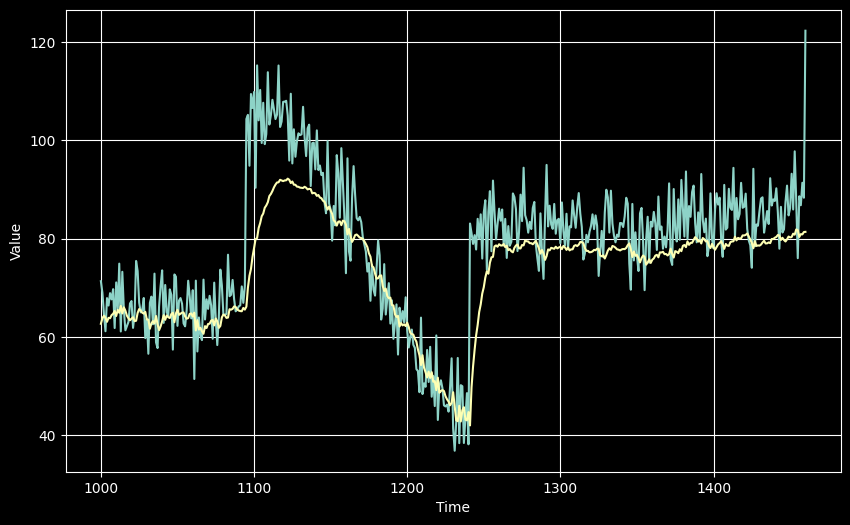

In [13]:
# Reduzir a série original
forecast_series = series[split_time-window_size:-1]

# Use a função auxiliar para gerar previsões
forecast = model_forecast(model, forecast_series, window_size, batch_size)

# Retirar eixo unidimensional
results = forecast.squeeze()

# Plotar os resultados
plot_series(time_valid, (x_valid, results))

Em seguida, você pode gerar as métricas para avaliar o desempenho do modelo.

In [14]:
# Calcular o MSE e o MAE
print(tf.keras.metrics.mean_squared_error(x_valid, results).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

88.36643
6.8350534


## Inclusão de um conjunto de validação durante o treinamento

Você já viu antes como também pode monitorar o desempenho do seu modelo em relação a um conjunto de validação durante o treinamento. Você também pode fazer isso neste laboratório. 

Primeiro, você precisa gerar um `val_set`, que são janelas de dados e rótulos que o modelo pode aceitar. Você pode simplesmente reutilizar a função `windowed_dataset` para isso e passar os pontos `x_valid` para gerar as janelas.

In [15]:
# Gerar janelas de dados do conjunto de validação
val_set = windowed_dataset(x_valid, window_size, batch_size, shuffle_buffer_size)

Em seguida, você pode fazer o mesmo treinamento de antes, mas passar o `val_set` para o parâmetro `validation_data` do método `fit()`.

In [16]:
# Redefinir estados gerados pelo Keras
tf.keras.backend.clear_session()

# Construir o modelo
model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
   tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

# Definir a taxa de aprendizado
learning_rate = 2e-6

# Definir o otimizador 
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

# Definir os parâmetros de treinamento
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# Treine o modelo
history = model.fit(dataset,epochs=100, validation_data=val_set)

Epoch 1/100
     26/Unknown - 3s 4ms/step - loss: 15.7857 - mae: 16.2792

2024-04-13 12:56:45.404278: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4692949217869808434


31/31 [==============================] - 4s 30ms/step - loss: 14.9076 - mae: 15.4017 - val_loss: 23.4786 - val_mae: 23.9776
Epoch 2/100
31/31 [==============================] - 0s 6ms/step - loss: 7.4846 - mae: 7.9709 - val_loss: 14.5053 - val_mae: 14.9973
Epoch 3/100
31/31 [==============================] - 0s 6ms/step - loss: 6.5209 - mae: 7.0043 - val_loss: 12.5968 - val_mae: 13.0878
Epoch 4/100
31/31 [==============================] - 0s 9ms/step - loss: 6.2190 - mae: 6.7019 - val_loss: 11.8050 - val_mae: 12.2945
Epoch 5/100
31/31 [==============================] - 0s 8ms/step - loss: 5.9801 - mae: 6.4615 - val_loss: 11.4854 - val_mae: 11.9799
Epoch 6/100
31/31 [==============================] - 0s 7ms/step - loss: 5.7869 - mae: 6.2631 - val_loss: 10.2725 - val_mae: 10.7587
Epoch 7/100
31/31 [==============================] - 0s 5ms/step - loss: 5.6419 - mae: 6.1242 - val_loss: 9.4993 - val_mae: 9.9865
Epoch 8/100
31/31 [==============================] - 0s 11ms/step - loss: 5.4783

## Conclusão

Isso conclui este breve exercício sobre o uso de LSTMs para previsão de séries temporais.

Nos próximos laboratórios você se baseará nisso e adicionará convoluções.

Em seguida, você começará a se afastar dos dados sintéticos e a usar conjuntos de dados do mundo real!